In [1]:
# !pip install seaborn
# !pip install openpyxl
# !pip install ccxt
# !sudo conda install -c conda-forge ta-lib -y
# !sudo pip uninstall tensorflow-gpu -y
# !sudo pip install tensorflow-gpu==2.6.5
#!conda install -c conda-forge ta-lib -y

In [28]:
import os
import math
import numpy as np
import pandas as pd
import ccxt
import talib
from datetime import datetime
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from script.fetch_history_data import binance_fetch_history_price, binance_single_fetch_history_price
from script.preprocess import *
from script.transformer_timestep import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [29]:
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
valid_percent = 20
test_percent = 10

ma_ptc_col_min = -0.04326610844852674
ma_ptc_col_max = 0.03996161803797027

In [30]:
df = binance_fetch_history_price(coin='BTC/USDT', timeframe='1h', start_date='2019-09-09')

In [31]:
timeframes = [10,20,40,60,80,100,120,140,160,180,200]
df = calculate_technical_indicators(df, timeframes=timeframes)
#ZhangDieFu_label = df['ZhangDieFu'].apply(lambda x:ZhangDieFu_label(x))
#z_score_df = calculate_z_score(df, z_score_dic(df))

In [32]:
df

,Timestamp,Open,High,Low,Close,Volume,open_MA_10,High_MA_10,Low_MA_10,Close_MA_10,Volume_MA_10,open_MA_ptc_10,High_MA_ptc_10,Low_MA_ptc_10,Close_MA_ptc_10,Volume_MA_ptc_10,Bias,Cmo_10,Atr_10,Cci_10,Volume_pct,ZhangDieFu,ZhenFu,Rsi_10,Ic_10,Macd,Signal,Histogram,UpperBB_10,MiddleBB_10,LowerBB_10,SlowK,SlowD,UpperMAE_10,MiddleMAE_10,LowerMAE_10,OBV,open_MA_20,High_MA_20,Low_MA_20,Close_MA_20,Volume_MA_20,open_MA_ptc_20,High_MA_ptc_20,Low_MA_ptc_20,Close_MA_ptc_20,Volume_MA_ptc_20,Cmo_20,Atr_20,Cci_20,Rsi_20,Ic_20,UpperBB_20,MiddleBB_20,LowerBB_20,UpperMAE_20,MiddleMAE_20,LowerMAE_20,open_MA_40,High_MA_40,Low_MA_40,Close_MA_40,Volume_MA_40,open_MA_ptc_40,High_MA_ptc_40,Low_MA_ptc_40,Close_MA_ptc_40,Volume_MA_ptc_40,Cmo_40,Atr_40,Cci_40,Rsi_40,Ic_40,UpperBB_40,MiddleBB_40,LowerBB_40,UpperMAE_40,MiddleMAE_40,LowerMAE_40,open_MA_60,High_MA_60,Low_MA_60,Close_MA_60,Volume_MA_60,open_MA_ptc_60,High_MA_ptc_60,Low_MA_ptc_60,Close_MA_ptc_60,Volume_MA_ptc_60,Cmo_60,Atr_60,Cci_60,Rsi_60,Ic_60,UpperBB_60,MiddleBB_60,LowerBB_60,UpperMAE_60,MiddleMAE_60,LowerMAE_60,open_MA_80,High_MA_80,Low_MA_80,Close_MA_80,Volume_MA_80,open_MA_ptc_80,High_MA_ptc_80,Low_MA_ptc_80,Close_MA_ptc_80,Volume_MA_ptc_80,Cmo_80,Atr_80,Cci_80,Rsi_80,Ic_80,UpperBB_80,MiddleBB_80,LowerBB_80,UpperMAE_80,MiddleMAE_80,LowerMAE_80,open_MA_100,High_MA_100,Low_MA_100,Close_MA_100,Volume_MA_100,open_MA_ptc_100,High_MA_ptc_100,Low_MA_ptc_100,Close_MA_ptc_100,Volume_MA_ptc_100,Cmo_100,Atr_100,Cci_100,Rsi_100,Ic_100,UpperBB_100,MiddleBB_100,LowerBB_100,UpperMAE_100,MiddleMAE_100,LowerMAE_100,open_MA_120,High_MA_120,Low_MA_120,Close_MA_120,Volume_MA_120,open_MA_ptc_120,High_MA_ptc_120,Low_MA_ptc_120,Close_MA_ptc_120,Volume_MA_ptc_120,Cmo_120,Atr_120,Cci_120,Rsi_120,Ic_120,UpperBB_120,MiddleBB_120,LowerBB_120,UpperMAE_120,MiddleMAE_120,LowerMAE_120,open_MA_140,High_MA_140,Low_MA_140,Close_MA_140,Volume_MA_140,open_MA_ptc_140,High_MA_ptc_140,Low_MA_ptc_140,Close_MA_ptc_140,Volume_MA_ptc_140,Cmo_140,Atr_140,Cci_140,Rsi_140,Ic_140,UpperBB_140,MiddleBB_140,LowerBB_140,UpperMAE_140,MiddleMAE_140,LowerMAE_140,open_MA_160,High_MA_160,Low_MA_160,Close_MA_160,Volume_MA_160,open_MA_ptc_160,High_MA_ptc_160,Low_MA_ptc_160,Close_MA_ptc_160,Volume_MA_ptc_160,Cmo_160,Atr_160,Cci_160,Rsi_160,Ic_160,UpperBB_160,MiddleBB_160,LowerBB_160,UpperMAE_160,MiddleMAE_160,LowerMAE_160,open_MA_180,High_MA_180,Low_MA_180,Close_MA_180,Volume_MA_180,open_MA_ptc_180,High_MA_ptc_180,Low_MA_ptc_180,Close_MA_ptc_180,Volume_MA_ptc_180,Cmo_180,Atr_180,Cci_180,Rsi_180,Ic_180,UpperBB_180,MiddleBB_180,LowerBB_180,UpperMAE_180,MiddleMAE_180,LowerMAE_180,open_MA_200,High_MA_200,Low_MA_200,Close_MA_200,Volume_MA_200,open_MA_ptc_200,High_MA_ptc_200,Low_MA_ptc_200,Close_MA_ptc_200,Volume_MA_ptc_200,Cmo_200,Atr_200,Cci_200,Rsi_200,Ic_200,UpperBB_200,MiddleBB_200,LowerBB_200,UpperMAE_200,MiddleMAE_200,LowerMAE_200
200,2019-09-17-08:00,10202.92,10205.81,10165.34,10171.85,963.979,10219.657,10231.860,10188.298,10207.543,916.1847,-0.000781,-0.001000,-0.001085,-0.001094,0.015755,-0.700968,-20.650978,44.647821,-66.666667,0.010513,-0.002945,0.003967,39.674511,-0.002730,-15.896851,-16.637351,0.740500,10249.346279,10207.543,10165.739721,33.820883,36.943462,10249.346279,10207.543,10165.739721,-7614.895,10188.8340,10214.2020,10164.7385,10189.5955,880.91835,-0.000388,-0.000373,0.000152,0.000122,-0.013535,-15.670096,45.713391,-66.666667,42.164952,-0.003775,10285.744731,10189.5955,10093.446269,10285.744731,10189.5955,10093.446269,10246.42375,10266.39375,10223.92450,10242.82925,864.102925,-0.000253,-0.000309,-0.000314,-0.000318,-0.000077,-10.381728,48.150597,-66.666667,44.809136,-0.005972,10380.205384,10242.82925,10105.453116,10380.205384,10242.82925,10105.453116,10269.339333,10287.652000,10241.124667,10265.464000,861.409717,-0.000261,-0.000311,-0.000319,-0.000362,0.003429,-7.828706,51.474166,-66.666667,46.085647,-0.007322,10397.376189,10265.464000,10133.551811,10397.376189,10265.464000,10133.551811,10280.992500,10300.703750,10255.072625,1027

In [5]:
ma_ptc_col = [col for col in df.columns if 'MA_ptc' in col and 'Volume' not in col]
ma_ptc_col_min = min(df[ma_ptc_col].min(axis=0))
ma_ptc_col_max = max(df[ma_ptc_col].max(axis=0))
for col in ma_ptc_col:
    df[col] = (df[col] - ma_ptc_col_min) / (ma_ptc_col_max - ma_ptc_col_min)

In [19]:
#df.to_pickle('./data/multi_factor_v2.0.0.pickle')

In [18]:
ma_ptc_col_max

0.03996161803797027

In [7]:
# minmax_dic = min_max_dic(df)
# minmax_df = calculate_min_max(df, minmax_dic)

In [16]:
# df.dropna()

,Timestamp,Open,High,Low,Close,Volume,open_MA_10,High_MA_10,Low_MA_10,Close_MA_10,Volume_MA_10,open_MA_ptc_10,High_MA_ptc_10,Low_MA_ptc_10,Close_MA_ptc_10,Volume_MA_ptc_10,Bias,Cmo_10,Atr_10,Cci_10,Volume_pct,ZhangDieFu,ZhenFu,Rsi_10,Ic_10,Macd,Signal,Histogram,UpperBB_10,MiddleBB_10,LowerBB_10,SlowK,SlowD,UpperMAE_10,MiddleMAE_10,LowerMAE_10,OBV,open_MA_20,High_MA_20,Low_MA_20,Close_MA_20,Volume_MA_20,open_MA_ptc_20,High_MA_ptc_20,Low_MA_ptc_20,Close_MA_ptc_20,Volume_MA_ptc_20,Cmo_20,Atr_20,Cci_20,Rsi_20,Ic_20,UpperBB_20,MiddleBB_20,LowerBB_20,UpperMAE_20,MiddleMAE_20,LowerMAE_20,open_MA_40,High_MA_40,Low_MA_40,Close_MA_40,Volume_MA_40,open_MA_ptc_40,High_MA_ptc_40,Low_MA_ptc_40,Close_MA_ptc_40,Volume_MA_ptc_40,Cmo_40,Atr_40,Cci_40,Rsi_40,Ic_40,UpperBB_40,MiddleBB_40,LowerBB_40,UpperMAE_40,MiddleMAE_40,LowerMAE_40,open_MA_60,High_MA_60,Low_MA_60,Close_MA_60,Volume_MA_60,open_MA_ptc_60,High_MA_ptc_60,Low_MA_ptc_60,Close_MA_ptc_60,Volume_MA_ptc_60,Cmo_60,Atr_60,Cci_60,Rsi_60,Ic_60,UpperBB_60,MiddleBB_60,LowerBB_60,UpperMAE_60,MiddleMAE_60,LowerMAE_60,open_MA_80,High_MA_80,Low_MA_80,Close_MA_80,Volume_MA_80,open_MA_ptc_80,High_MA_ptc_80,Low_MA_ptc_80,Close_MA_ptc_80,Volume_MA_ptc_80,Cmo_80,Atr_80,Cci_80,Rsi_80,Ic_80,UpperBB_80,MiddleBB_80,LowerBB_80,UpperMAE_80,MiddleMAE_80,LowerMAE_80,open_MA_100,High_MA_100,Low_MA_100,Close_MA_100,Volume_MA_100,open_MA_ptc_100,High_MA_ptc_100,Low_MA_ptc_100,Close_MA_ptc_100,Volume_MA_ptc_100,Cmo_100,Atr_100,Cci_100,Rsi_100,Ic_100,UpperBB_100,MiddleBB_100,LowerBB_100,UpperMAE_100,MiddleMAE_100,LowerMAE_100,open_MA_120,High_MA_120,Low_MA_120,Close_MA_120,Volume_MA_120,open_MA_ptc_120,High_MA_ptc_120,Low_MA_ptc_120,Close_MA_ptc_120,Volume_MA_ptc_120,Cmo_120,Atr_120,Cci_120,Rsi_120,Ic_120,UpperBB_120,MiddleBB_120,LowerBB_120,UpperMAE_120,MiddleMAE_120,LowerMAE_120,open_MA_140,High_MA_140,Low_MA_140,Close_MA_140,Volume_MA_140,open_MA_ptc_140,High_MA_ptc_140,Low_MA_ptc_140,Close_MA_ptc_140,Volume_MA_ptc_140,Cmo_140,Atr_140,Cci_140,Rsi_140,Ic_140,UpperBB_140,MiddleBB_140,LowerBB_140,UpperMAE_140,MiddleMAE_140,LowerMAE_140,open_MA_160,High_MA_160,Low_MA_160,Close_MA_160,Volume_MA_160,open_MA_ptc_160,High_MA_ptc_160,Low_MA_ptc_160,Close_MA_ptc_160,Volume_MA_ptc_160,Cmo_160,Atr_160,Cci_160,Rsi_160,Ic_160,UpperBB_160,MiddleBB_160,LowerBB_160,UpperMAE_160,MiddleMAE_160,LowerMAE_160,open_MA_180,High_MA_180,Low_MA_180,Close_MA_180,Volume_MA_180,open_MA_ptc_180,High_MA_ptc_180,Low_MA_ptc_180,Close_MA_ptc_180,Volume_MA_ptc_180,Cmo_180,Atr_180,Cci_180,Rsi_180,Ic_180,UpperBB_180,MiddleBB_180,LowerBB_180,UpperMAE_180,MiddleMAE_180,LowerMAE_180,open_MA_200,High_MA_200,Low_MA_200,Close_MA_200,Volume_MA_200,open_MA_ptc_200,High_MA_ptc_200,Low_MA_ptc_200,Close_MA_ptc_200,Volume_MA_ptc_200,Cmo_200,Atr_200,Cci_200,Rsi_200,Ic_200,UpperBB_200,MiddleBB_200,LowerBB_200,UpperMAE_200,MiddleMAE_200,LowerMAE_200


In [6]:
df = pd.read_pickle('./data/multi_factor_v2.0.0.pickle')
minmax_df = df.copy()
del minmax_df['Timestamp']

In [7]:
len([col for col in minmax_df.columns[minmax_df.corr()['Close_MA_ptc_10'].abs() >=0.2]])
filterd_col = [col for col in minmax_df.columns[minmax_df.corr()['Close_MA_ptc_10'].abs() >=0.2]]

In [12]:
df[filterd_col].head()

,open_MA_ptc_10,High_MA_ptc_10,Low_MA_ptc_10,Close_MA_ptc_10,Bias,Cmo_10,Cci_10,ZhangDieFu,Rsi_10,Ic_10,Macd,Signal,Histogram,SlowK,SlowD,open_MA_ptc_20,High_MA_ptc_20,Low_MA_ptc_20,Close_MA_ptc_20,Cmo_20,Cci_20,Rsi_20,Ic_20,open_MA_ptc_40,High_MA_ptc_40,Low_MA_ptc_40,Close_MA_ptc_40,Cmo_40,Cci_40,Rsi_40,Ic_40,open_MA_ptc_60,High_MA_ptc_60,Low_MA_ptc_60,Close_MA_ptc_60,Cmo_60,Cci_60,Rsi_60,Ic_60,open_MA_ptc_80,High_MA_ptc_80,Low_MA_ptc_80,Close_MA_ptc_80,Cmo_80,Cci_80,Rsi_80,Ic_80,open_MA_ptc_100,High_MA_ptc_100,Low_MA_ptc_100,Close_MA_ptc_100,Cmo_100,Cci_100,Rsi_100,Ic_100,open_MA_ptc_120,High_MA_ptc_120,Low_MA_ptc_120,Close_MA_ptc_120,Cmo_120,Cci_120,Rsi_120,Ic_120,open_MA_ptc_140,High_MA_ptc_140,Low_MA_ptc_140,Close_MA_ptc_140,Cmo_140,Cci_140,Rsi_140,Ic_140,open_MA_ptc_160,High_MA_ptc_160,Low_MA_ptc_160,Close_MA_ptc_160,Cmo_160,Cci_160,Rsi_160,Ic_160,open_MA_ptc_180,High_MA_ptc_180,Low_MA_ptc_180,Close_MA_ptc_180,Cmo_180,Cci_180,Rsi_180,Ic_180,High_MA_ptc_200,Low_MA_ptc_200,Close_MA_ptc_200,Cmo_200,Cci_200,Rsi_200,Ic_200
200,0.510471,0.507832,0.506816,0.506708,-0.700968,-20.650978,-66.666667,-0.002945,39.674511,-0.002730,-15.896851,-16.637351,0.740500,33.820883,36.943462,0.515189,0.515371,0.521677,0.521312,-15.670096,-66.666667,42.164952,-0.003775,0.516808,0.516143,0.516076,0.516033,-10.381728,-66.666667,44.809136,-0.005972,0.516719,0.516113,0.516019,0.515498,-7.828706,-66.666667,46.085647,-0.007322,0.517806,0.517696,0.517937,0.517848,-6.909947,-66.666667,46.545026,-0.008036,0.517960,0.517590,0.517985,0.517924,-5.962955,-66.666667,47.018523,-0.008042,0.521051,0.520380,0.520715,0.520091,-5.368552,-66.666667,47.315724,-0.007829,0.521029,0.520742,0.520829,0.520520,-4.861845,-66.666667,47.569078,-0.007334,0.520078,0.519621,0.519802,0.519459,-4.491100,-66.666667,47.754450,-0.006878,0.519168,0.518456,0.519441,0.519448,-4.224830,-66.666667,47.887585,-0.006517,0.518766,0.518521,0.518563,-4.205398,-66.666667,47.897301,-0.007096
201,0.506491,0.506240,0.508985,0.509666,-0.778913,-24.473011,-66.666667,-0.000897,37.763494,-0.002970,-17.820243,-16.873929,-0.946314,33.212934,37.092110,0.521198,0.519383,0.520506,0.520677,-17.637581,-66.666667,41.181210,-0.004230,0.516014,0.515650,0.515442,0.515562,-11.403348,-66.666667,44.298326,-0.006539,0.515487,0.515026,0.516320,0.515658,-8.483619,-66.666667,45.758190,-0.007956,0.517852,0.517714,0.517608,0.517869,-7.374348,-66.666667,46.312826,-0.008719,0.518011,0.517852,0.518259,0.518342,-6.319256,-66.666667,46.840372,-0.008769,0.520081,0.519853,0.520030,0.520252,-5.656487,-66.666667,47.171756,-0.008589,0.520481,0.520442,0.520852,0.520907,-5.104183,-66.666667,47.447909,-0.008121,0.519477,0.519409,0.519423,0.519478,-4.701354,-66.666667,47.649323,-0.007685,0.519472,0.518735,0.519246,0.519026,-4.411469,-66.666667,47.794266,-0.007338,0.518568,0.518353,0.518510,-4.373113,-66.666667,47.813444,-0.007920
202,0.508540,0.510578,0.518198,0.514387,-0.698036,-19.118456,-66.666667,0.000754,40.440772,-0.001812,-18.513040,-17.201751,-1.311289,28.976770,32.003529,0.520497,0.520767,0.522582,0.521842,-15.260089,-66.666667,42.369956,-0.003143,0.515514,0.516118,0.516235,0.516362,-10.319979,-66.666667,44.840010,-0.005499,0.515628,0.515852,0.516637,0.516615,-7.829197,-66.666667,46.085401,-0.006961,0.517828,0.518031,0.518301,0.518303,-6.920670,-66.666667,46.539665,-0.007763,0.518339,0.518250,0.518519,0.518389,-5.978585,-66.666667,47.010707,-0.007851,0.520218,0.519897,0.520227,0.520012,-5.384902,-66.666667,47.307549,-0.007700,0.520890,0.520849,0.521316,0.521025,-4.878187,-66.666667,47.560906,-0.007258,0.519468,0.519587,0.519622,0.519648,-4.506906,-66.666667,47.746547,-0.006840,0.519016,0.518706,0.519013,0.518624,-4.239901,-66.666667,47.880050,-0.006506,0.519067,0.519069,0.519115,-4.219089,-66.666667,47.890456,-0.007090
203,0.514427,0.512766,0.515556,0.514377,-0.763656,-22.683725,-66.666667,-0.000727,38.658137,-0.002078,-19.434370,-17.648275,-1.786095,36.783486,32.991063,0.521751,0.520834,0.522135,0.522383,-16.964325,-66.666667

In [9]:
minmax_df = df[filterd_col]

In [10]:
df_train, df_val, df_test = preprocess_train_test_split(minmax_df, valid_percent=valid_percent, test_percent=test_percent)
X_train, y_train = preprocess_sequence_data(df_train, target_column='Close_MA_ptc_10', seq_len=seq_len)
X_val, y_val = preprocess_sequence_data(df_val, target_column='Close_MA_ptc_10', seq_len=seq_len)
X_test, y_test = preprocess_sequence_data(df_test, target_column='Close_MA_ptc_10', seq_len=seq_len)

In [11]:
X_train, y_train = preprocess_sequence_data(df_train, target_column='Close_MA_ptc_10', seq_len=128)
X_val, y_val = preprocess_sequence_data(df_val, target_column='Close_MA_ptc_10', seq_len=128)
X_test, y_test = preprocess_sequence_data(df_test, target_column='Close_MA_ptc_10', seq_len=128)

In [10]:
# from keras.utils import np_utils
# y_train = np_utils.to_categorical(y_train)
# y_val = np_utils.to_categorical(y_val)
# y_test = np_utils.to_categorical(y_test)

In [11]:
y_test

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [12]:
feature_count = X_train.shape[2]
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, feature_count))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=in_seq, outputs=out)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,
                                                                decay_steps=10000,
                                                                decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mape'])
    return model

model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./model_weight/transformer_btc_multi_factor_v2.0.0.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

2023-03-13 11:28:12.506198: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 11:28:13.285020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47176 MB memory:  -> device: 0, name: NVIDIA Quadro RTX 8000, pci bus id: 0000:21:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 94)]    0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 96)      0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 96)      1238848     concatenate[0][0]            

In [13]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

2023-03-13 11:28:20.682519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/35


2023-03-13 11:28:47.259157: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


858/858 [==============================] - 619s 689ms/step - loss: 0.0074 - mae: 0.0469 - mape: 9.0827 - val_loss: 6.2071e-04 - val_mae: 0.0190 - val_mape: 3.7214

Epoch 00001: val_loss improved from inf to 0.00062, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.0.hdf5
Epoch 2/35
858/858 [==============================] - 583s 680ms/step - loss: 0.0017 - mae: 0.0320 - mape: 6.2291 - val_loss: 5.5785e-04 - val_mae: 0.0181 - val_mape: 3.5333

Epoch 00002: val_loss improved from 0.00062 to 0.00056, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.0.hdf5
Epoch 3/35
858/858 [==============================] - 584s 681ms/step - loss: 0.0015 - mae: 0.0291 - mape: 5.6554 - val_loss: 3.9817e-04 - val_mae: 0.0138 - val_mape: 2.6447

Epoch 00003: val_loss improved from 0.00056 to 0.00040, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.0.hdf5
Epoch 4/35
858/858 [==============================] - 584s 680ms/step - loss: 0.0010 - mae: 0.0240 - mape:

In [14]:
model = tf.keras.models.load_model('./model_weight/transformer_btc_multi_factor_v2.0.0.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred   = model.predict(X_val)
test_pred  = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval   = model.evaluate(X_val, y_val, verbose=0)
test_eval  = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_eval[0], test_eval[1]))

 
Evaluation metrics
Training Data - Loss: 0.0001, MAE: 0.0075
Validation Data - Loss: 0.0001, MAE: 0.0063
Test Data - Loss: 0.0001, MAE: 0.0069


In [21]:
df.tail()

,Timestamp,Open,High,Low,Close,Volume,open_MA_10,High_MA_10,Low_MA_10,Close_MA_10,Volume_MA_10,open_MA_ptc_10,High_MA_ptc_10,Low_MA_ptc_10,Close_MA_ptc_10,Volume_MA_ptc_10,Bias,Cmo_10,Atr_10,Cci_10,Volume_pct,ZhangDieFu,ZhenFu,Rsi_10,Ic_10,Macd,Signal,Histogram,UpperBB_10,MiddleBB_10,LowerBB_10,SlowK,SlowD,UpperMAE_10,MiddleMAE_10,LowerMAE_10,OBV,open_MA_20,High_MA_20,Low_MA_20,Close_MA_20,Volume_MA_20,open_MA_ptc_20,High_MA_ptc_20,Low_MA_ptc_20,Close_MA_ptc_20,Volume_MA_ptc_20,Cmo_20,Atr_20,Cci_20,Rsi_20,Ic_20,UpperBB_20,MiddleBB_20,LowerBB_20,UpperMAE_20,MiddleMAE_20,LowerMAE_20,open_MA_40,High_MA_40,Low_MA_40,Close_MA_40,Volume_MA_40,open_MA_ptc_40,High_MA_ptc_40,Low_MA_ptc_40,Close_MA_ptc_40,Volume_MA_ptc_40,Cmo_40,Atr_40,Cci_40,Rsi_40,Ic_40,UpperBB_40,MiddleBB_40,LowerBB_40,UpperMAE_40,MiddleMAE_40,LowerMAE_40,open_MA_60,High_MA_60,Low_MA_60,Close_MA_60,Volume_MA_60,open_MA_ptc_60,High_MA_ptc_60,Low_MA_ptc_60,Close_MA_ptc_60,Volume_MA_ptc_60,Cmo_60,Atr_60,Cci_60,Rsi_60,Ic_60,UpperBB_60,MiddleBB_60,LowerBB_60,UpperMAE_60,MiddleMAE_60,LowerMAE_60,open_MA_80,High_MA_80,Low_MA_80,Close_MA_80,Volume_MA_80,open_MA_ptc_80,High_MA_ptc_80,Low_MA_ptc_80,Close_MA_ptc_80,Volume_MA_ptc_80,Cmo_80,Atr_80,Cci_80,Rsi_80,Ic_80,UpperBB_80,MiddleBB_80,LowerBB_80,UpperMAE_80,MiddleMAE_80,LowerMAE_80,open_MA_100,High_MA_100,Low_MA_100,Close_MA_100,Volume_MA_100,open_MA_ptc_100,High_MA_ptc_100,Low_MA_ptc_100,Close_MA_ptc_100,Volume_MA_ptc_100,Cmo_100,Atr_100,Cci_100,Rsi_100,Ic_100,UpperBB_100,MiddleBB_100,LowerBB_100,UpperMAE_100,MiddleMAE_100,LowerMAE_100,open_MA_120,High_MA_120,Low_MA_120,Close_MA_120,Volume_MA_120,open_MA_ptc_120,High_MA_ptc_120,Low_MA_ptc_120,Close_MA_ptc_120,Volume_MA_ptc_120,Cmo_120,Atr_120,Cci_120,Rsi_120,Ic_120,UpperBB_120,MiddleBB_120,LowerBB_120,UpperMAE_120,MiddleMAE_120,LowerMAE_120,open_MA_140,High_MA_140,Low_MA_140,Close_MA_140,Volume_MA_140,open_MA_ptc_140,High_MA_ptc_140,Low_MA_ptc_140,Close_MA_ptc_140,Volume_MA_ptc_140,Cmo_140,Atr_140,Cci_140,Rsi_140,Ic_140,UpperBB_140,MiddleBB_140,LowerBB_140,UpperMAE_140,MiddleMAE_140,LowerMAE_140,open_MA_160,High_MA_160,Low_MA_160,Close_MA_160,Volume_MA_160,open_MA_ptc_160,High_MA_ptc_160,Low_MA_ptc_160,Close_MA_ptc_160,Volume_MA_ptc_160,Cmo_160,Atr_160,Cci_160,Rsi_160,Ic_160,UpperBB_160,MiddleBB_160,LowerBB_160,UpperMAE_160,MiddleMAE_160,LowerMAE_160,open_MA_180,High_MA_180,Low_MA_180,Close_MA_180,Volume_MA_180,open_MA_ptc_180,High_MA_ptc_180,Low_MA_ptc_180,Close_MA_ptc_180,Volume_MA_ptc_180,Cmo_180,Atr_180,Cci_180,Rsi_180,Ic_180,UpperBB_180,MiddleBB_180,LowerBB_180,UpperMAE_180,MiddleMAE_180,LowerMAE_180,open_MA_200,High_MA_200,Low_MA_200,Close_MA_200,Volume_MA_200,open_MA_ptc_200,High_MA_ptc_200,Low_MA_ptc_200,Close_MA_ptc_200,Volume_MA_ptc_200,Cmo_200,Atr_200,Cci_200,Rsi_200,Ic_200,UpperBB_200,MiddleBB_200,LowerBB_200,UpperMAE_200,MiddleMAE_200,LowerMAE_200
30812,2023-03-13-07:00,22372.9,22488.4,22307.6,22451.6,32626.652,22112.68,22370.78,21998.44,22231.53,54332.5888,0.581233,0.584890,0.584782,0.584447,0.001466,4.649710,60.193910,294.610630,66.666667,0.246272,0.003522,0.008081,80.096955,0.015180,536.413239,459.313182,77.100057,22676.626484,22231.53,21786.433516,79.521584,72.622900,22676.626484,22231.53,21786.433516,-3042100.274,21361.425,21594.640,21260.450,21462.245,52435.3682,0.575166,0.575748,0.573807,0.576566,0.015028,52.126294,267.385816,66.666667,76.063147,0.034932,23115.818653,21462.245,19808.671347,23115.818653,21462.245,19808.671347,20840.1025,20995.8250,20766.0800,20900.0650,34864.159125,0.552673,0.553587,0.552901,0.554435,0.011292,34.250089,236.267620,66.666667,67.125044,0.056497,22527.053343,20900.0650,19273.076657,22527.053343,20900.0650,19273.076657,20612.936667,20753.171667,20530.648333,20653.536667,34454.645500,0.544524,0.543306,0.544008,0.543521,0.001687,23.336483,217.372856,66.666667,61.668242,0.064568,22168.274870,20653.536667,19138.798463,22168.274870,20653.536667,19138.798463,20448.44375,20582.98250,20349.55875,20474.72875,40010.198950,0.534887,0.535

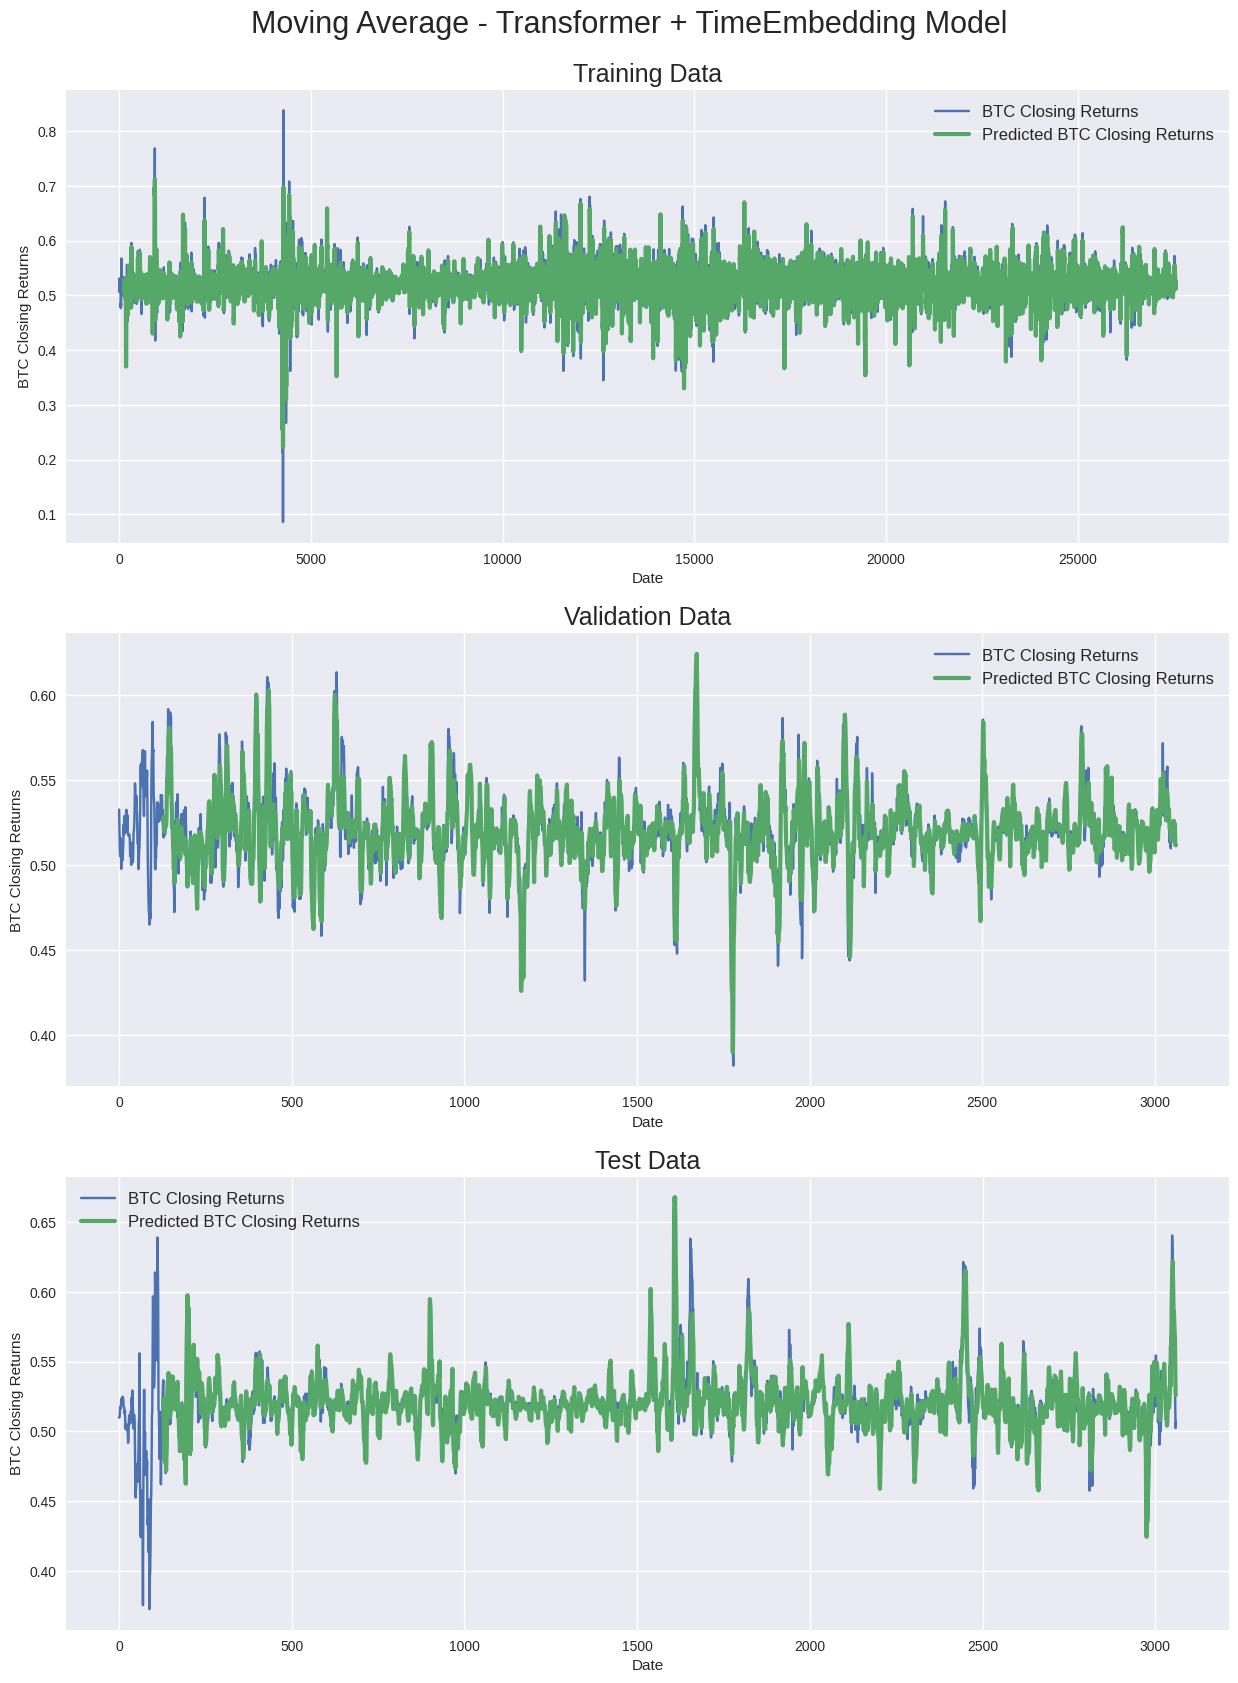

In [17]:

#'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(df_train.values[:, 3], label='BTC Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(df_val.values[:, 3], label='BTC Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(df_test.values[:, 3], label='BTC Closing Returns')
ax31.plot(np.arange(seq_len, test_pred[:].shape[0]+seq_len), test_pred[:], linewidth=3, label='Predicted BTC Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [39]:
df_test['pred_Close_MA_ptc_10'] = '-'
df_test['pred_Close_MA_ptc_10'][seq_len:] = test_pred.flatten()

In [45]:
df = pd.read_pickle('./data/multi_factor_v2.0.0.pickle')
df_test['Close'] = df['Close'][df_test.index]
df_test['Close_MA_10'] = df['Close_MA_10'][df_test.index]
df_test.to_pickle('./output_file/20230315_multi_factor_v2.0.0.pickle')

In [43]:
df_test['Close'].tail(10)

30807    22174.5
30808    22221.7
30809    22309.1
30810    22387.4
30811    22372.8
30812    22451.6
30813    22185.3
30814    21956.0
30815    22113.0
30816    22031.1
Name: Close, dtype: float64

In [42]:
df['Close'].tail(10)

30807    22174.5
30808    22221.7
30809    22309.1
30810    22387.4
30811    22372.8
30812    22451.6
30813    22185.3
30814    21956.0
30815    22113.0
30816    22031.1
Name: Close, dtype: float64

In [44]:
df.tail()

,Timestamp,Open,High,Low,Close,Volume,open_MA_10,High_MA_10,Low_MA_10,Close_MA_10,Volume_MA_10,open_MA_ptc_10,High_MA_ptc_10,Low_MA_ptc_10,Close_MA_ptc_10,Volume_MA_ptc_10,Bias,Cmo_10,Atr_10,Cci_10,Volume_pct,ZhangDieFu,ZhenFu,Rsi_10,Ic_10,Macd,Signal,Histogram,UpperBB_10,MiddleBB_10,LowerBB_10,SlowK,SlowD,UpperMAE_10,MiddleMAE_10,LowerMAE_10,OBV,open_MA_20,High_MA_20,Low_MA_20,Close_MA_20,Volume_MA_20,open_MA_ptc_20,High_MA_ptc_20,Low_MA_ptc_20,Close_MA_ptc_20,Volume_MA_ptc_20,Cmo_20,Atr_20,Cci_20,Rsi_20,Ic_20,UpperBB_20,MiddleBB_20,LowerBB_20,UpperMAE_20,MiddleMAE_20,LowerMAE_20,open_MA_40,High_MA_40,Low_MA_40,Close_MA_40,Volume_MA_40,open_MA_ptc_40,High_MA_ptc_40,Low_MA_ptc_40,Close_MA_ptc_40,Volume_MA_ptc_40,Cmo_40,Atr_40,Cci_40,Rsi_40,Ic_40,UpperBB_40,MiddleBB_40,LowerBB_40,UpperMAE_40,MiddleMAE_40,LowerMAE_40,open_MA_60,High_MA_60,Low_MA_60,Close_MA_60,Volume_MA_60,open_MA_ptc_60,High_MA_ptc_60,Low_MA_ptc_60,Close_MA_ptc_60,Volume_MA_ptc_60,Cmo_60,Atr_60,Cci_60,Rsi_60,Ic_60,UpperBB_60,MiddleBB_60,LowerBB_60,UpperMAE_60,MiddleMAE_60,LowerMAE_60,open_MA_80,High_MA_80,Low_MA_80,Close_MA_80,Volume_MA_80,open_MA_ptc_80,High_MA_ptc_80,Low_MA_ptc_80,Close_MA_ptc_80,Volume_MA_ptc_80,Cmo_80,Atr_80,Cci_80,Rsi_80,Ic_80,UpperBB_80,MiddleBB_80,LowerBB_80,UpperMAE_80,MiddleMAE_80,LowerMAE_80,open_MA_100,High_MA_100,Low_MA_100,Close_MA_100,Volume_MA_100,open_MA_ptc_100,High_MA_ptc_100,Low_MA_ptc_100,Close_MA_ptc_100,Volume_MA_ptc_100,Cmo_100,Atr_100,Cci_100,Rsi_100,Ic_100,UpperBB_100,MiddleBB_100,LowerBB_100,UpperMAE_100,MiddleMAE_100,LowerMAE_100,open_MA_120,High_MA_120,Low_MA_120,Close_MA_120,Volume_MA_120,open_MA_ptc_120,High_MA_ptc_120,Low_MA_ptc_120,Close_MA_ptc_120,Volume_MA_ptc_120,Cmo_120,Atr_120,Cci_120,Rsi_120,Ic_120,UpperBB_120,MiddleBB_120,LowerBB_120,UpperMAE_120,MiddleMAE_120,LowerMAE_120,open_MA_140,High_MA_140,Low_MA_140,Close_MA_140,Volume_MA_140,open_MA_ptc_140,High_MA_ptc_140,Low_MA_ptc_140,Close_MA_ptc_140,Volume_MA_ptc_140,Cmo_140,Atr_140,Cci_140,Rsi_140,Ic_140,UpperBB_140,MiddleBB_140,LowerBB_140,UpperMAE_140,MiddleMAE_140,LowerMAE_140,open_MA_160,High_MA_160,Low_MA_160,Close_MA_160,Volume_MA_160,open_MA_ptc_160,High_MA_ptc_160,Low_MA_ptc_160,Close_MA_ptc_160,Volume_MA_ptc_160,Cmo_160,Atr_160,Cci_160,Rsi_160,Ic_160,UpperBB_160,MiddleBB_160,LowerBB_160,UpperMAE_160,MiddleMAE_160,LowerMAE_160,open_MA_180,High_MA_180,Low_MA_180,Close_MA_180,Volume_MA_180,open_MA_ptc_180,High_MA_ptc_180,Low_MA_ptc_180,Close_MA_ptc_180,Volume_MA_ptc_180,Cmo_180,Atr_180,Cci_180,Rsi_180,Ic_180,UpperBB_180,MiddleBB_180,LowerBB_180,UpperMAE_180,MiddleMAE_180,LowerMAE_180,open_MA_200,High_MA_200,Low_MA_200,Close_MA_200,Volume_MA_200,open_MA_ptc_200,High_MA_ptc_200,Low_MA_ptc_200,Close_MA_ptc_200,Volume_MA_ptc_200,Cmo_200,Atr_200,Cci_200,Rsi_200,Ic_200,UpperBB_200,MiddleBB_200,LowerBB_200,UpperMAE_200,MiddleMAE_200,LowerMAE_200
30812,2023-03-13-07:00,22372.9,22488.4,22307.6,22451.6,32626.652,22112.68,22370.78,21998.44,22231.53,54332.5888,0.581233,0.584890,0.584782,0.584447,0.001466,4.649710,60.193910,294.610630,66.666667,0.246272,0.003522,0.008081,80.096955,0.015180,536.413239,459.313182,77.100057,22676.626484,22231.53,21786.433516,79.521584,72.622900,22676.626484,22231.53,21786.433516,-3042100.274,21361.425,21594.640,21260.450,21462.245,52435.3682,0.575166,0.575748,0.573807,0.576566,0.015028,52.126294,267.385816,66.666667,76.063147,0.034932,23115.818653,21462.245,19808.671347,23115.818653,21462.245,19808.671347,20840.1025,20995.8250,20766.0800,20900.0650,34864.159125,0.552673,0.553587,0.552901,0.554435,0.011292,34.250089,236.267620,66.666667,67.125044,0.056497,22527.053343,20900.0650,19273.076657,22527.053343,20900.0650,19273.076657,20612.936667,20753.171667,20530.648333,20653.536667,34454.645500,0.544524,0.543306,0.544008,0.543521,0.001687,23.336483,217.372856,66.666667,61.668242,0.064568,22168.274870,20653.536667,19138.798463,22168.274870,20653.536667,19138.798463,20448.44375,20582.98250,20349.55875,20474.72875,40010.198950,0.534887,0.535